# Recommender System

**Agenda**

1. Data cleansing
    - Fix data types
    - Dispose of negative values
2. Data analysis
    - Time-based analysis
    - User-based analysis
    - Branch-based analysis
3. Modeling
    - Basket analysis
    - Implicit-feedback collaboraive filtering
    - Most frequent items recommendation
    - Random item recommendation
4. Expected Income estimation

**Dependencies**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn3, venn3_circles
import seaborn as sns
from matplotlib.colors import ListedColormap

import pyspark.sql.functions as f
from pyspark.sql.window import Window
from pyspark.sql.types import TimestampType, DoubleType, DataType
from pyspark.ml.fpm import FPGrowth
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row

from IPython.display import Markdown, display
# pd.set_option('display.max_colwidth', -1)

## 1. Data cleansing

In [2]:
df = spark.read.option('header', 'true').csv('../../como_data_rev/item/items_1.csv')
df.toPandas().head(10)

,member_id,purchase_id,purchase_time_stamp,branch_id,department_code,item_code,quantity,final_price
0,2ncmnBbwN8stuui46WHKRA==,YF3q/aCxyDCODl8lGhsgVA==,2018-04-29 21:39:01 UTC,orbQkLpM7JyCDmgoYC68sw==,None,BkCWYyJq8vMRRIWqTgojtA==,1,12.17
1,2ncmnBbwN8stuui46WHKRA==,YF3q/aCxyDCODl8lGhsgVA==,2018-04-29 21:39:01 UTC,orbQkLpM7JyCDmgoYC68sw==,None,qrMjiSK8wlpvYG61Jf/cVg==,1,4.23
2,2ncmnBbwN8stuui46WHKRA==,YF3q/aCxyDCODl8lGhsgVA==,2018-04-29 21:39:01 UTC,orbQkLpM7JyCDmgoYC68sw==,None,WKL8btOf0IP1XUGCv4iCbQ==,1,0
3,2ncmnBbwN8stuui46WHKRA==,YF3q/aCxyDCODl8lGhsgVA==,2018-04-29 21:39:01 UTC,orbQkLpM7JyCDmgoYC68sw==,None,HDg80wt8KYq1ApOt/st7GA==,1,8.47
4,j0dG5ZYV1MSas1LPkLQj6A==,S+KqJ+tonGsuDyBPlPgebQ==,2018-04-30 20:31:15 UTC,orbQkLpM7JyCDmgoYC68sw==,None,WKL8btOf0IP1XUGCv4iCbQ==,1,0
5,j0dG5ZYV1MSas1LPkLQj6A==,S+KqJ+tonGsuDyBPlPgebQ==,2018-04-30 20:31:15 UTC,orbQkLpM7JyCDmgoYC68sw==,None,tzzjmMOfUGr3YdInfYU6kg==,2,16.94
6,e8OIi1sqeF9XfJ/wjnqurw==,kjvKZHJoD6gUZ+On7dQLbw==,2018-04-30 20:22:10 UTC,orbQkLpM7JyCDmgoYC68sw==,None,peABMjc6cDEAD9mHo8n4ew==,2,4.86
7,e8OIi1sqeF9XfJ/wjnqurw==,kjvKZHJoD6gUZ+On7dQLbw==,2018-04-30 20:22:10 UTC,orbQkLpM7JyCDmgoYC68sw==,None,tzzjmMOfUGr3YdInfYU6kg==,1,8.46
8,e8OIi1sqeF9XfJ/wjnqurw==,kjvKZHJoD6gUZ+On7dQLbw==,2018-04-30 20:22:10 UTC,orbQkLpM7JyCDmgoYC68sw==,None,WKL8btOf0IP1XUGCv4iCbQ==,1,0
9,7vZ7lQd9rLIOgT2xcHp1Uw==,jjOVkoFTVKhMZC9DNFGhdQ==,2018-04-24 23:15:00 UTC,orbQkLpM7JyCDmgoYC68sw==,None,peABMjc6cDEAD9mHo8n4ew==,1,2.43


**Fix data types**

In [9]:
df.printSchema()

root
 |-- member_id: string (nullable = true)
 |-- purchase_id: string (nullable = true)
 |-- purchase_time_stamp: string (nullable = true)
 |-- branch_id: string (nullable = true)
 |-- department_code: string (nullable = true)
 |-- item_code: string (nullable = true)
 |-- quantity: string (nullable = true)
 |-- final_price: string (nullable = true)



In [10]:
columns = df.columns
df = df.withColumn('quantity_', f.col('quantity').cast(DoubleType())).drop('quantity')\
                 .withColumn('final_price_', f.col('final_price').cast(DoubleType())).drop('final_price')\
                 .toDF(*columns)
df.printSchema()

root
 |-- member_id: string (nullable = true)
 |-- purchase_id: string (nullable = true)
 |-- purchase_time_stamp: string (nullable = true)
 |-- branch_id: string (nullable = true)
 |-- department_code: string (nullable = true)
 |-- item_code: string (nullable = true)
 |-- quantity: double (nullable = true)
 |-- final_price: double (nullable = true)



**Dispose of negative values**

In [11]:
df.groupBy('quantity').agg(f.count('*')).orderBy('quantity').show()

+--------+--------+
|quantity|count(1)|
+--------+--------+
|    -5.0|       1|
|    -3.0|       1|
|    -2.0|      10|
|    -1.0|     330|
|     1.0|   23010|
|     2.0|     746|
|     3.0|     124|
|     4.0|      39|
|     5.0|      17|
|     6.0|       6|
|     7.0|       2|
|     8.0|       2|
|     9.0|       1|
|    10.0|       4|
+--------+--------+



In [12]:
df = df.where(f.col('quantity') > 0)
df.groupBy('quantity').agg(f.count('*')).orderBy('quantity').show()

+--------+--------+
|quantity|count(1)|
+--------+--------+
|     1.0|   23010|
|     2.0|     746|
|     3.0|     124|
|     4.0|      39|
|     5.0|      17|
|     6.0|       6|
|     7.0|       2|
|     8.0|       2|
|     9.0|       1|
|    10.0|       4|
+--------+--------+



## 2. Data analysis

**members**

Total number of members: **2368**

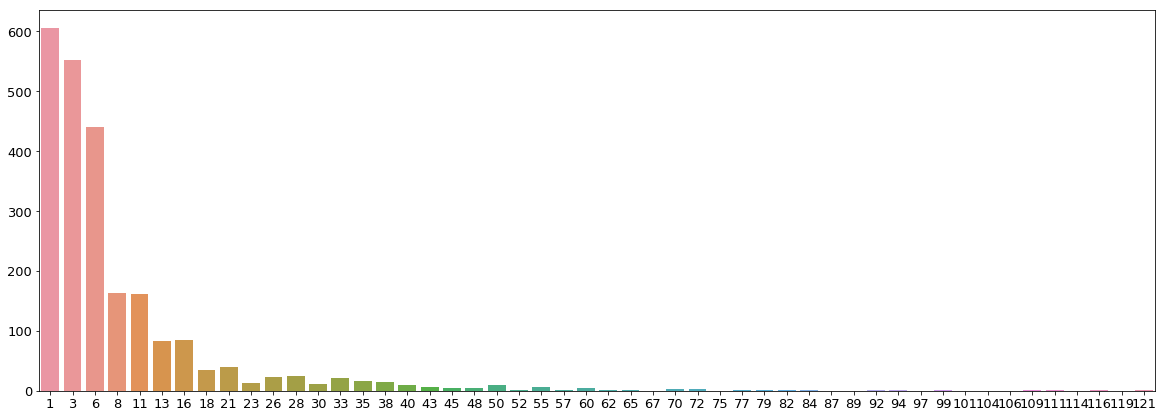

In [13]:
members = df.groupBy('member_id').agg(f.count('*').alias('count')).orderBy(f.col('count').desc())
display(Markdown('Total number of members: **{}**'.format(members.count())))
bins, counts = members.select('count').rdd.flatMap(lambda x: x).histogram(100)
# print bins, counts
plt.figure(figsize=(20,7))
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
_ = sns.barplot([int(round(x)) for x in bins[:50]], counts[:50])

**branches**

Total number of branches: **12**

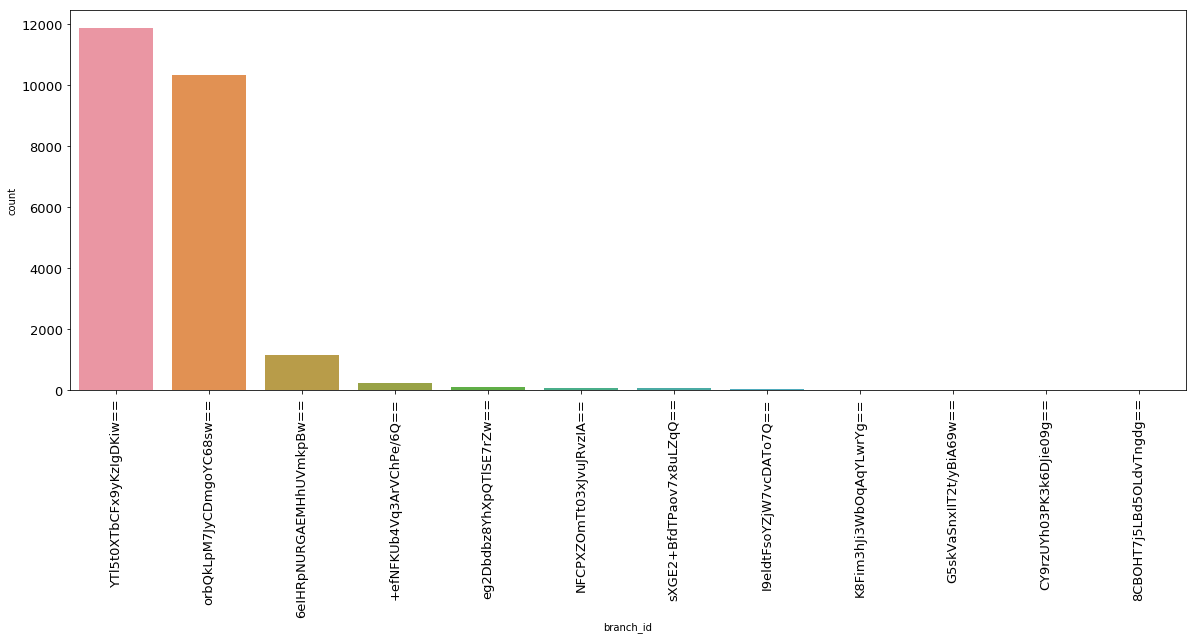

In [14]:
branches = df.groupBy('branch_id').agg(f.count('*').alias('count')).orderBy(f.col('count').desc())
display(Markdown('Total number of branches: **{}**'.format(branches.count())))
branches_pd = branches.toPandas()
plt.figure(figsize=(20,7))
plt.xticks(fontsize=13, rotation=90)
plt.yticks(fontsize=13)
_ = sns.barplot(branches_pd['branch_id'], branches_pd['count'])

**Items**

Total number of items: **900**

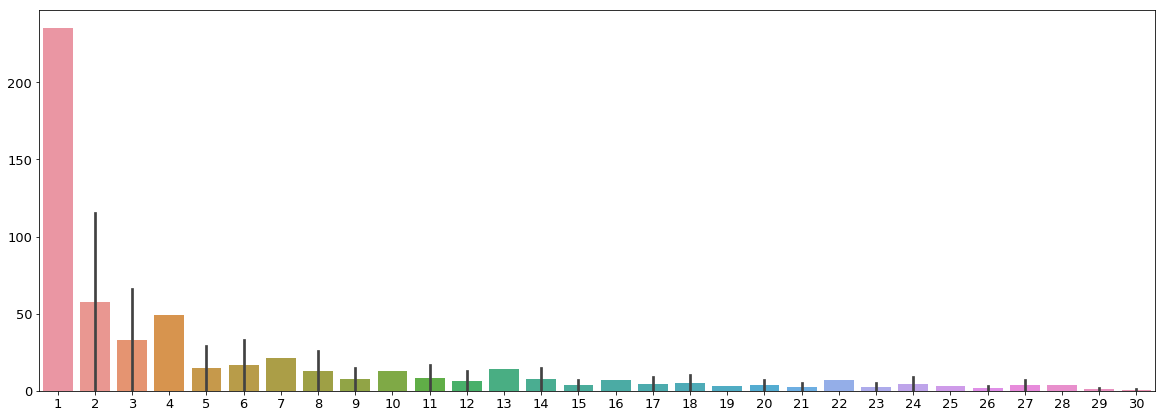

In [15]:
items = df.groupBy('item_code').agg(f.sum('quantity').alias('quantity')).orderBy(f.col('quantity').desc())
display(Markdown('Total number of items: **{}**'.format(items.count())))
bins, counts = items.select('quantity').rdd.flatMap(lambda x: x).histogram(3000)
plt.figure(figsize=(20,7))
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
_ = sns.barplot([int(round(x)) for x in bins[:50]], counts[:50])

### Time-based analysis

In order to determine whether or not we can base our recommendation on a specific time segment (month, week, day etc.), we will analyse and visualize multiple time-segments

In [16]:
df = df.withColumn('timestamp', f.unix_timestamp(f.regexp_replace(df['purchase_time_stamp'], 'UTC', ''), 'yyyy-MM-dd HH:mm:ss').cast(TimestampType()))\
                 .withColumn('date', f.col('timestamp').cast('date'))\
                 .withColumn('year', f.year(f.col('timestamp')))\
                 .withColumn('month', f.month(f.col('timestamp')))\
                 .withColumn('week_of_year', f.weekofyear(f.col('timestamp')))\
                 .withColumn('day_of_month', f.dayofmonth(f.col('timestamp')))\
                 .withColumn('day_of_week_int', f.dayofweek(f.col('timestamp')))\
                 .withColumn('day_of_Week', f.date_format(f.col('timestamp'), 'EEEE'))\
                 .withColumn('hour', f.hour(f.col('timestamp')))
df.toPandas().head()

,member_id,purchase_id,purchase_time_stamp,branch_id,department_code,item_code,quantity,final_price,timestamp,date,year,month,week_of_year,day_of_month,day_of_week_int,day_of_Week,hour
0,2ncmnBbwN8stuui46WHKRA==,YF3q/aCxyDCODl8lGhsgVA==,2018-04-29 21:39:01 UTC,orbQkLpM7JyCDmgoYC68sw==,None,BkCWYyJq8vMRRIWqTgojtA==,1.0,12.17,2018-04-29 21:39:01,2018-04-29,2018,4,17,29,1,Sunday,21
1,2ncmnBbwN8stuui46WHKRA==,YF3q/aCxyDCODl8lGhsgVA==,2018-04-29 21:39:01 UTC,orbQkLpM7JyCDmgoYC68sw==,None,qrMjiSK8wlpvYG61Jf/cVg==,1.0,4.23,2018-04-29 21:39:01,2018-04-29,2018,4,17,29,1,Sunday,21
2,2ncmnBbwN8stuui46WHKRA==,YF3q/aCxyDCODl8lGhsgVA==,2018-04-29 21:39:01 UTC,orbQkLpM7JyCDmgoYC68sw==,None,WKL8btOf0IP1XUGCv4iCbQ==,1.0,0.00,2018-04-29 21:39:01,2018-04-29,2018,4,17,29,1,Sunday,21
3,2ncmnBbwN8stuui46WHKRA==,YF3q/aCxyDCODl8lGhsgVA==,2018-04-29 21:39:01 UTC,orbQkLpM7JyCDmgoYC68sw==,None,HDg80wt8KYq1ApOt/st7GA==,1.0,8.47,2018-04-29 21:39:01,2018-04-29,2018,4,17,29,1,Sunday,21
4,j0dG5ZYV1MSas1LPkLQj6A==,S+KqJ+tonGsuDyBPlPgebQ==,2018-04-30 20:31:15 UTC,orbQkLpM7JyCDmgoYC68sw==,None,WKL8btOf0IP1XUGCv4iCbQ==,1.0,0.00,2018-04-30 20:31:15,2018-04-30,2018,4,18,30,2,Monday,20


**Year**

In [17]:
df.groupBy('year').agg(f.count('*')).show()

+----+--------+
|year|count(1)|
+----+--------+
|2018|   23951|
+----+--------+



**Date**

- search for trends in the different parameters (number of members, income...)

In [18]:
date = df.groupBy('date').agg(f.countDistinct('item_code').alias('distinct_items'),
                                   f.countDistinct('member_id').alias('members'),
                                   f.sum('quantity').alias('quantity'),
                                   f.sum('final_price').alias('income')).orderBy('date')
date.show()

+----------+--------------+-------+--------+------------------+
|      date|distinct_items|members|quantity|            income|
+----------+--------------+-------+--------+------------------+
|2018-03-08|             4|      1|     4.0|36.510000000000005|
|2018-03-15|             9|      2|    22.0|220.73000000000002|
|2018-03-18|             3|      5|    10.0|             100.0|
|2018-03-19|             2|      2|     6.0|             140.0|
|2018-03-22|             2|      1|     2.0|              2.43|
|2018-03-23|            21|      6|    33.0|185.12999999999994|
|2018-03-24|            24|     11|    45.0|285.72999999999985|
|2018-03-25|            11|      4|    16.0|            133.63|
|2018-03-26|             8|      2|    13.0|             60.93|
|2018-03-27|             7|      3|     9.0|             34.71|
|2018-03-28|            44|     20|   114.0|             696.9|
|2018-03-29|            10|      3|    13.0| 86.47000000000001|
|2018-03-30|            16|      5|    3

[Text(0,0.5,u''), Text(0.5,0,u''), Text(0.5,1,u'Daily income')]

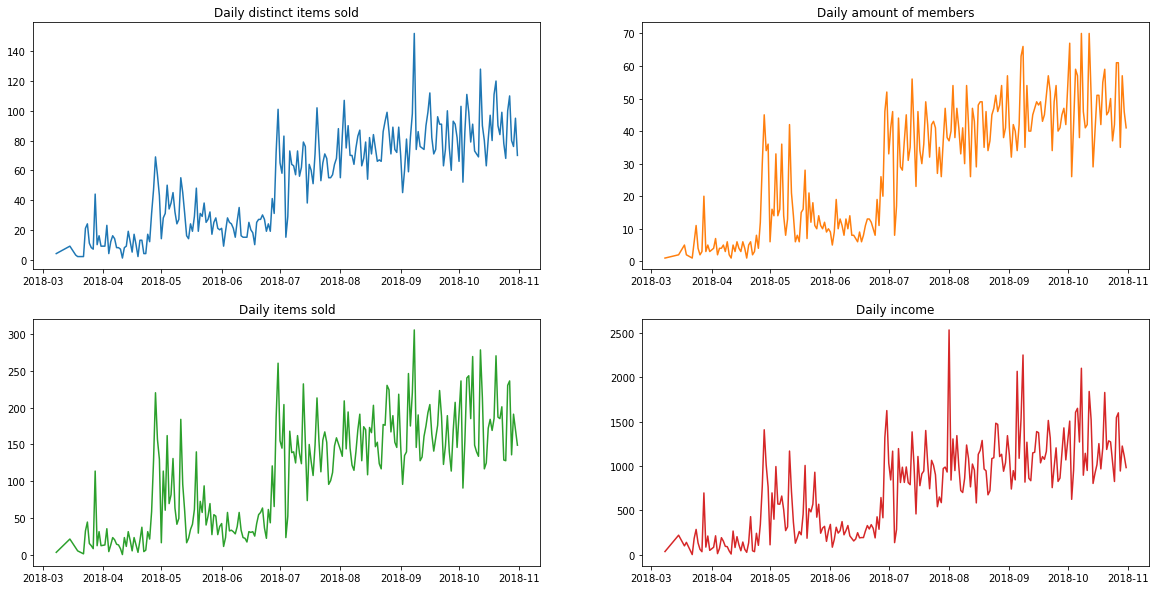

In [19]:
date_pd = date.toPandas()
fig, axs = plt.subplots(2, 2, figsize=(20, 10))
sns.lineplot(x='date', y='distinct_items', data=date_pd, ax=axs[0][0], color='C0').set(xlabel='', ylabel='', title='Daily distinct items sold')
sns.lineplot(x='date', y='members', data=date_pd, ax=axs[0][1], color='C1').set(xlabel='', ylabel='', title='Daily amount of members')
sns.lineplot(x='date', y='quantity', data=date_pd, ax=axs[1][0], color='C2').set(xlabel='', ylabel='', title='Daily items sold')
sns.lineplot(x='date', y='income', data=date_pd, ax=axs[1][1], color='C3').set(xlabel='', ylabel='', title='Daily income')

Conclusions:
- We can observe a positive trend within the data in all the parameters, but it doesn't necessarily indicates that there is actually a trend in the real data, it can be cause by other factors as well such as:
    - activity scale has changed
    - the sampled data received for the project is biased

**Month**

- search for intra-monthly trends
- look for significant items in a specific month

In [20]:
month = df.groupBy('month').agg(f.countDistinct('item_code').alias('distinct_items'),
                                     f.countDistinct('member_id').alias('members'),
                                     f.sum('quantity').alias('quantity'),
                                     f.sum('final_price').alias('income')).orderBy('month')
month.show()

+-----+--------------+-------+--------+------------------+
|month|distinct_items|members|quantity|            income|
+-----+--------------+-------+--------+------------------+
|    3|            85|     59|   332.0|2244.4700000000003|
|    4|           129|    195|  1107.0| 7208.930000000012|
|    5|           153|    311|  2074.0|14601.120000000074|
|    6|           227|    274|  1601.0| 10628.48000000002|
|    7|           470|    723|  4296.0|27297.239999999947|
|    8|           437|    832|  5051.0| 33509.76999999993|
|    9|           548|    866|  5082.0| 34955.45000000024|
|   10|           557|    907|  5687.0|38385.280000000195|
+-----+--------------+-------+--------+------------------+



[Text(0,0.5,u''), Text(0.5,0,u''), Text(0.5,1,u'Monthly income')]

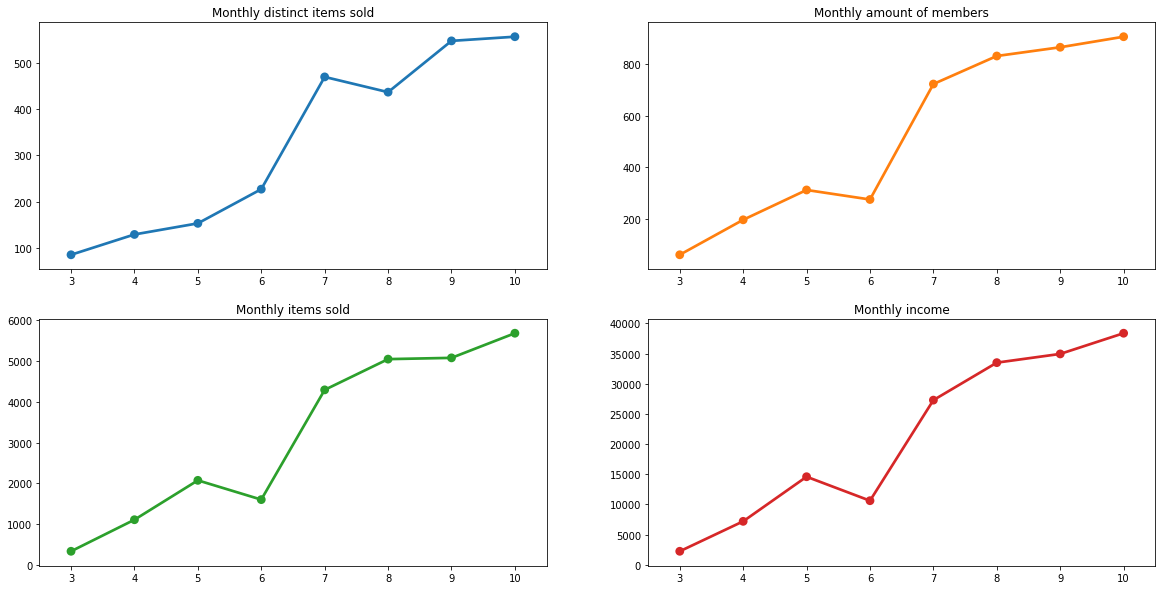

In [21]:
month_pd = month.toPandas()
fig, axs = plt.subplots(2, 2, figsize=(20, 10))
sns.pointplot(x='month', y='distinct_items', data=month_pd, legend=True, ax=axs[0][0], color='C0').set(xlabel='', ylabel='', title='Monthly distinct items sold')
sns.pointplot(x='month', y='members', data=month_pd, legend=True, ax=axs[0][1], color='C1').set(xlabel='', ylabel='', title='Monthly amount of members')
sns.pointplot(x='month', y='quantity', data=month_pd, legend=True, ax=axs[1][0], color='C2').set(xlabel='', ylabel='', title='Monthly items sold')
sns.pointplot(x='month', y='income', data=month_pd, legend=True, ax=axs[1][1], color='C3').set(xlabel='', ylabel='', title='Monthly income')

3 most popular items in each month

+-----+------------------------+----------+----+
|month|item_code               |item_units|rank|
+-----+------------------------+----------+----+
|3    |WKL8btOf0IP1XUGCv4iCbQ==|62.0      |1   |
|3    |peABMjc6cDEAD9mHo8n4ew==|45.0      |2   |
|3    |tzzjmMOfUGr3YdInfYU6kg==|31.0      |3   |
|4    |WKL8btOf0IP1XUGCv4iCbQ==|183.0     |1   |
|4    |peABMjc6cDEAD9mHo8n4ew==|153.0     |2   |
|4    |tzzjmMOfUGr3YdInfYU6kg==|116.0     |3   |
|5    |peABMjc6cDEAD9mHo8n4ew==|337.0     |1   |
|5    |WKL8btOf0IP1XUGCv4iCbQ==|256.0     |2   |
|5    |tzzjmMOfUGr3YdInfYU6kg==|194.0     |3   |
|6    |peABMjc6cDEAD9mHo8n4ew==|202.0     |1   |
|6    |tzzjmMOfUGr3YdInfYU6kg==|134.0     |2   |
|6    |WKL8btOf0IP1XUGCv4iCbQ==|111.0     |3   |
|7    |jHu7upXBAll15UjO6G363A==|332.0     |1   |
|7    |EfUkw/v+7KSqkW7ctrY5Lg==|330.0     |2   |
|7    |RSvyCL+QEyKWhVcie49u/g==|290.0     |3   |
|8    |EfUkw/v+7KSqkW7ctrY5Lg==|532.0     |1   |
|8    |RSvyCL+QEyKWhVcie49u/g==|273.0     |2   |
|8    |peABMjc6cDEAD

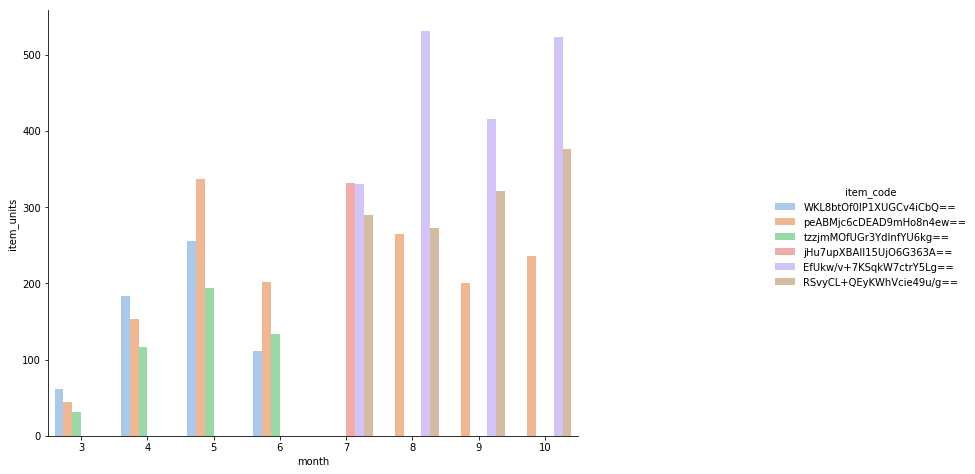

In [22]:
window = Window \
    .partitionBy(f.col('month')) \
    .orderBy(f.col('item_units').desc())

month_items = df.groupBy('month', 'item_code') \
                     .agg(f.sum('quantity').alias('item_units')) \
                     .withColumn('rank', f.row_number().over(window)) \
                     .where(f.col('rank') <= 3) \
                     .orderBy('month', f.col('item_units').desc())
month_items.show(truncate=False)

g = sns.catplot(x='month', y="item_units", hue="item_code", palette="pastel", kind="bar", data=month_items.toPandas())
g.fig.set_size_inches(15,7)

Conclusions:
- item "peABMjc6cDEAD9mHo8n4ew==" is popular in every month
- the other two were changed between June and July
- it will be taken into consideration when we will do the recommendations

**Day of Month**
- see if there are any popular days within the month (e.g, 10bis leftovers)
- see if specific items are purchased in speceific days of month
- income trend within the month

+-----+------------+-------+------------------+
|month|day_of_month|members|            income|
+-----+------------+-------+------------------+
|    3|           8|      1|36.510000000000005|
|    3|          15|      2|220.73000000000002|
|    3|          18|      5|             100.0|
|    3|          19|      2|             140.0|
|    3|          22|      1|              2.43|
|    3|          23|      6|            185.13|
|    3|          24|     11|285.72999999999996|
|    3|          25|      4|            133.63|
|    3|          26|      2|             60.93|
|    3|          27|      3|             34.71|
|    3|          28|     20|             696.9|
|    3|          29|      3|             86.47|
|    3|          30|      5|211.50000000000003|
|    3|          31|      3|              49.8|
|    4|           2|      4|             84.88|
|    4|           3|      7|213.99000000000004|
|    4|           4|      2|             13.01|
|    4|           5|      4|            

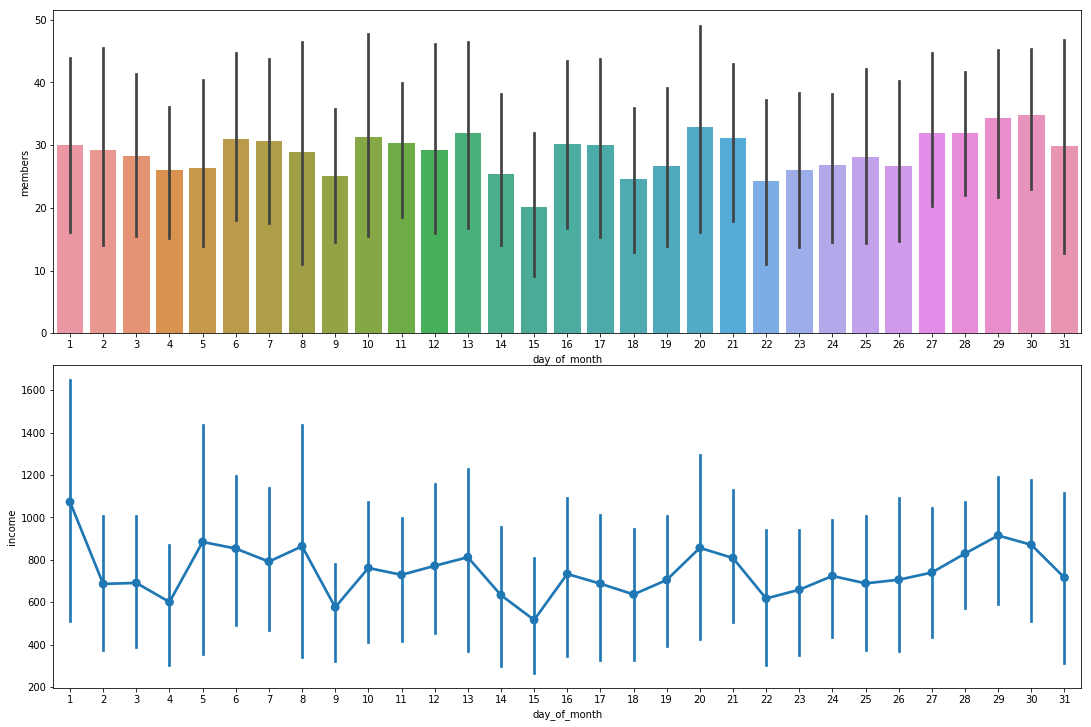

In [23]:
dom = df.groupBy('month', 'day_of_month')\
    .agg(f.countDistinct('member_id').alias('members'),
         f.sum('final_price').alias('income'))\
    .orderBy('month', 'day_of_month')
dom.show()

dom_pd = dom.toPandas()
fig, axs = plt.subplots(2, 1, figsize=(15, 10))
fig.tight_layout()
sns.barplot(x='day_of_month', y='members', data=dom_pd, ax=axs[0])
sns.pointplot(x='day_of_month', y='income', data=dom_pd, ax=axs[1])

item_code,EfUkw/v+7KSqkW7ctrY5Lg==,RSvyCL+QEyKWhVcie49u/g==,WKL8btOf0IP1XUGCv4iCbQ==,jHu7upXBAll15UjO6G363A==,peABMjc6cDEAD9mHo8n4ew==,tzzjmMOfUGr3YdInfYU6kg==,z80ghJXVZe9m59/5+Ydk2g==
day_of_month,,,,,,,
1,43.0,NaN,NaN,39.0,NaN,NaN,42.0
2,47.0,NaN,NaN,45.0,39.0,NaN,NaN
3,51.0,NaN,NaN,38.0,39.0,NaN,NaN
4,30.0,NaN,45.0,NaN,70.0,NaN,NaN
5,52.0,NaN,NaN,NaN,41.0,38.0,NaN


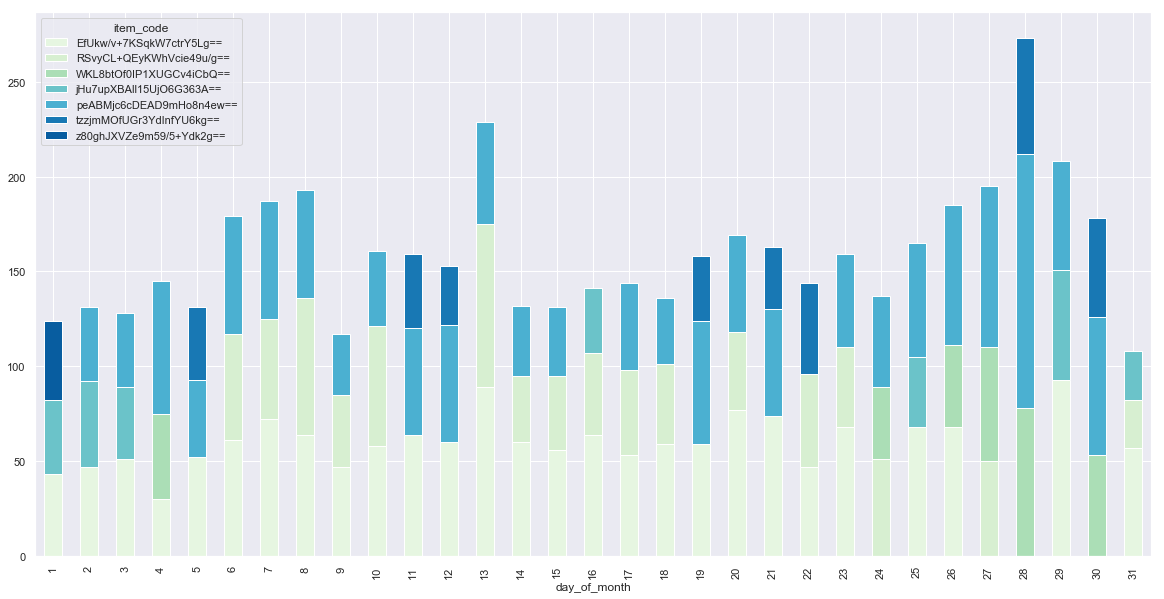

In [24]:
window = Window \
    .partitionBy(f.col('day_of_month')) \
    .orderBy(f.col('item_units').desc())

dom_items = df.groupBy('day_of_month', 'item_code') \
                     .agg(f.sum('quantity').alias('item_units')) \
                     .withColumn('rank', f.row_number().over(window)) \
                     .where(f.col('rank') <= 3) \
                     .orderBy('day_of_month', f.col('item_units').desc())

sns.set()
month_pivted = pd.pivot_table(dom_items.toPandas(), values='item_units', index='day_of_month', columns='item_code', aggfunc=np.sum)
display(month_pivted.head())
month_pivted.plot(kind='bar', stacked=True, figsize=(20, 10), colormap=ListedColormap(sns.color_palette("GnBu", 10)))

Conclusion:
- hard to find a significant difference in the number of members based on day of month
- no difference in income either
- we do see at the end of the month a different most popular item

**day_of_week**
- are there more members on weekend related to weekdays or vise versa?

+-----+---------------+-----------+-------+--------+------------------+
|month|day_of_week_int|day_of_Week|members|quantity|            income|
+-----+---------------+-----------+-------+--------+------------------+
|    3|              1|     Sunday|      9|    26.0|            233.63|
|    3|              2|     Monday|      4|    19.0|            200.93|
|    3|              3|    Tuesday|      3|     9.0|             34.71|
|    3|              4|  Wednesday|     20|   114.0| 696.8999999999999|
|    3|              5|   Thursday|      7|    41.0|346.14000000000004|
|    3|              6|     Friday|     11|    65.0|396.62999999999994|
|    3|              7|   Saturday|     14|    58.0|            335.53|
|    4|              1|     Sunday|     40|   197.0|1267.8000000000002|
|    4|              2|     Monday|     46|   171.0|1020.8699999999995|
|    4|              3|    Tuesday|     21|   101.0|            643.79|
|    4|              4|  Wednesday|     11|    42.0|189.58999999

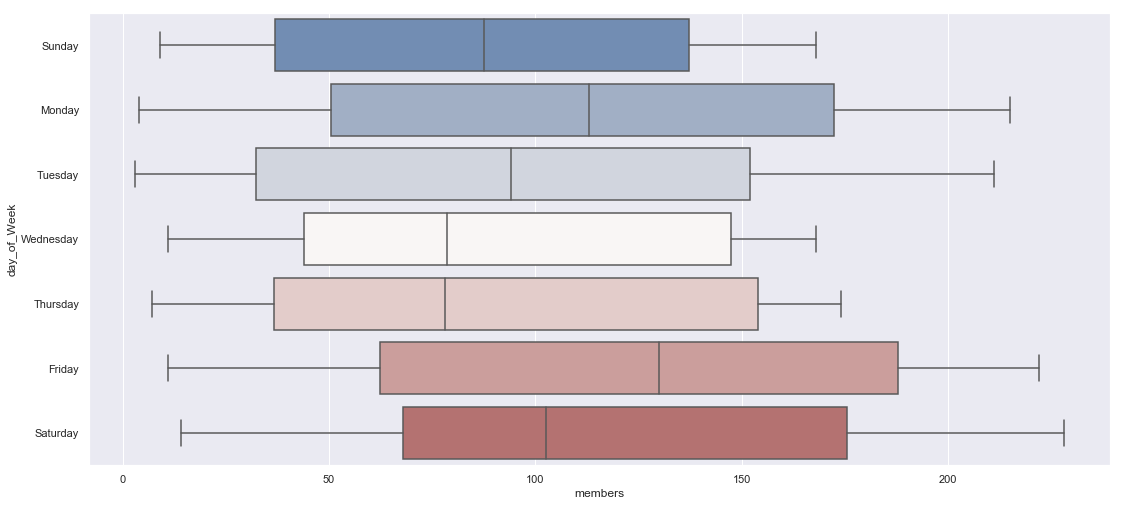

In [25]:
dow = df.groupBy('month', 'day_of_week_int', 'day_of_Week')\
             .agg(f.countDistinct('member_id').alias('members'),
                  f.sum('quantity').alias('quantity'),
                  f.sum('final_price').alias('income')).orderBy('month', 'day_of_week_int')
dow.show()

dow_pd = dow.toPandas()
fig, axs = plt.subplots(1, 1, figsize=(15, 7))
fig.tight_layout()
sns.boxplot(x='members', y='day_of_Week', data=dow_pd, whis='range', palette='vlag', ax=axs)

Conclusion:
- Friday and Satuday are the most popular days (especially Friday)

### User-based analysis

In [3]:
dist_pivoted = df.groupBy('member_id').pivot('item_code').agg(f.sum('quantity')).na.fill(0)
pivoted = dist_pivoted.toPandas().set_index('member_id')
# pivoted = pd.pivot_table(df.toPandas(), values='quantity', index=['member_id'], columns=['item_code'], aggfunc=np.sum, fill_value=0).astype(float)
pivoted.head()

,+6nYgWTz4tkQnudwIjISoA==,+9eTnWdJl820aS003oYzxA==,+AvwVScVeowqe7Y7IvSaqg==,+JkTnfXhBZOWQxQV53DG3Q==,+Q8qylxkAonQopQXvLY6Nw==,+Xa1e7ndJ6oufn3ygliTpg==,+h6cllMUzNeBD7Xqg4MD5Q==,+jo8QH+CN39VwZxdQDM1xw==,+qy81b8dAYkSwRa/J4PpoQ==,+s+fdDsIMAiolO7nuqFkaQ==,...,zL2MqWK4BEXfH384xXdZ8A==,zQy8xmj+S8WOCvPMfgplPQ==,zWOj7sMxn9nITJQqCDFuAA==,zachd+ujYP8Wt/g24nVDcA==,zmySMD840pfiY8cYDwPUAg==,znWECPbvmNfHp7eG7KezqA==,znjR2iVMCEPrI5Ua4Hf/Xw==,zt67bocvU5vvjD+RmHTp1w==,zujWt85SVU/XA1Tje79Eog==,zvq0QrFyinwbScY/GlV4HA==
member_id,,,,,,,,,,,,,,,,,,,,,
IPKLX1E2sYio8xj0Q2j8sA==,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
hmblJu9fezicxylkbsoCMw==,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
v0vltc8wY8qo3wL1OmIjQA==,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
z18stJ6CyMjzgiFI1k1u3Q==,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
qvFtfG5sIVq4YZKd7JZqMQ==,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


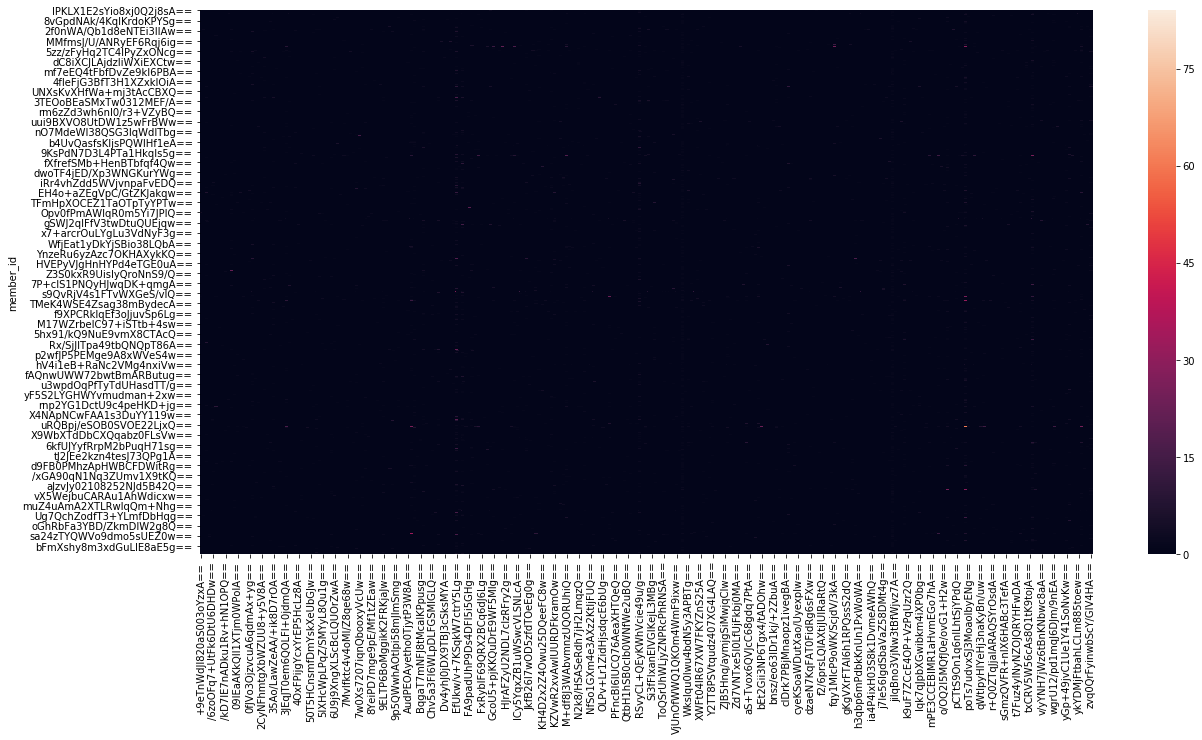

In [4]:
colsums = pivoted.values.sum(axis=0)
pivoted_freq_items = pivoted.loc[:,colsums > 10]

plt.figure(figsize=(20,10))
sns.heatmap(pivoted_freq_items)

In [5]:
member_freq_dist = df.groupBy('member_id')\
                          .agg(f.count('*').alias('transactions'))
member_freq_dist.orderBy(f.col('transactions').desc()).show()

member_freq = member_freq_dist.toPandas()
count, division = np.histogram(member_freq.transactions, bins=50)
division = ['{}-{}'.format(d, division[i+1]) for i, d in enumerate(division[:-1])]
pd.DataFrame(data={'division': division, 'count': count}).head()

+--------------------+------------+
|           member_id|transactions|
+--------------------+------------+
|s1fRnDVMdrQMjLJT2...|         246|
|sfCr2sV2pKJO+8Y6Q...|         203|
|ZdougbDUrj8EY4jDX...|         183|
|qTCvbM8hIR/cduoBb...|         151|
|ETunUA5upZEq3b5aL...|         139|
|qZC4yhD2W5BiHdFVZ...|         135|
|mOc6oOvJk2YY9TUE1...|         134|
|fLzYLnuXMamE11gVH...|         122|
|AmTox7h/mKDwktgQ7...|         122|
|RkqHG5MUrGU7etImh...|         117|
|fIELG7B7JbWHUcdXJ...|         112|
|bFmXshy8m3xdGuLlE...|         100|
|lBkJ3t4yPQ4wFd4hU...|          96|
|ORnqb7bGHlkh2j4Vp...|          96|
|xr7Aqi7Y9mniUA5Ta...|          93|
|/6StMmuQkxWl1ZLF0...|          85|
|YOp/3YJnfzYjakzQq...|          82|
|bzr4gTOAcpdviQBDM...|          81|
|gp31dB2uHeMFhJNgE...|          80|
|0j9KjEKhvcU6GAjYK...|          80|
+--------------------+------------+
only showing top 20 rows



,count,division
0,1156,1.0-5.9
1,597,5.9-10.8
2,244,10.8-15.7
3,121,15.7-20.6
4,55,20.6-25.5


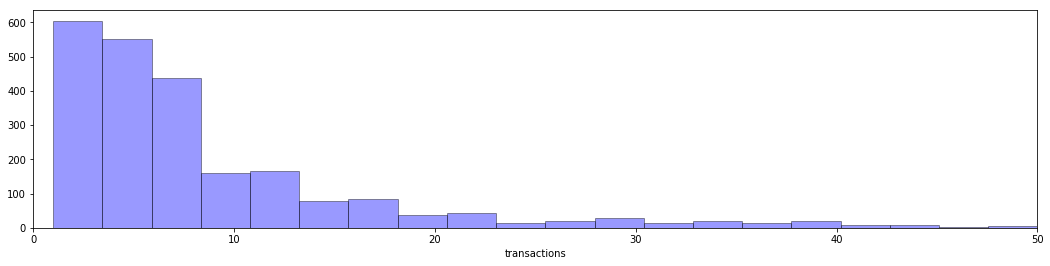

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(18,4))
_ = sns.distplot(member_freq['transactions'], hist=True, kde=False, 
             bins=100, color = 'blue',
             hist_kws={'edgecolor':'black'}, ax=ax).set(xlim=(0, 50))

### Branches analysis
- items ovelap between branches
- members ovelap between branches

In [7]:
df.groupBy('branch_id') \
    .agg(f.count('*').alias('transactions'), 
         f.countDistinct('item_code').alias('items'),
         f.countDistinct('member_id').alias('members')) \
    .orderBy(f.col('transactions').desc()) \
    .show(truncate=False)

+------------------------+------------+-----+-------+
|branch_id               |transactions|items|members|
+------------------------+------------+-----+-------+
|YTl5t0XTbCFx9yKzIgDKiw==|12142       |339  |1265   |
|orbQkLpM7JyCDmgoYC68sw==|10382       |206  |926    |
|6eIHRpNURGAEMHhUVmkpBw==|1156        |138  |86     |
|+efNFKUb4Vq3ArVChPe/6Q==|270         |81   |43     |
|eg2Dbdbz8YhXpQTlSE7rZw==|97          |52   |23     |
|NFCPXZOmTt03xJvuJRvzIA==|74          |39   |21     |
|sXGE2+BfdTPaov7x8uLZqQ==|72          |46   |19     |
|I9eldtFsoYZjW7vcDATo7Q==|44          |25   |14     |
|K8Fim3hJi3WbOqAqYLwrYg==|25          |16   |8      |
|G5skVaSnxIIT2t/yBiA69w==|13          |7    |4      |
|CY9rzUYh03PK3k6DJie09g==|12          |3    |6      |
|8CBOHT7j5LBd5OLdvTngdg==|6           |3    |3      |
+------------------------+------------+-----+-------+



Items overlap - all branches

,+6nYgWTz4tkQnudwIjISoA==,+9eTnWdJl820aS003oYzxA==,+AvwVScVeowqe7Y7IvSaqg==,+JkTnfXhBZOWQxQV53DG3Q==,+Q8qylxkAonQopQXvLY6Nw==,+Xa1e7ndJ6oufn3ygliTpg==,+h6cllMUzNeBD7Xqg4MD5Q==,+jo8QH+CN39VwZxdQDM1xw==,+qy81b8dAYkSwRa/J4PpoQ==,+s+fdDsIMAiolO7nuqFkaQ==,...,zL2MqWK4BEXfH384xXdZ8A==,zQy8xmj+S8WOCvPMfgplPQ==,zWOj7sMxn9nITJQqCDFuAA==,zachd+ujYP8Wt/g24nVDcA==,zmySMD840pfiY8cYDwPUAg==,znWECPbvmNfHp7eG7KezqA==,znjR2iVMCEPrI5Ua4Hf/Xw==,zt67bocvU5vvjD+RmHTp1w==,zujWt85SVU/XA1Tje79Eog==,zvq0QrFyinwbScY/GlV4HA==
branch_id,,,,,,,,,,,,,,,,,,,,,
I9eldtFsoYZjW7vcDATo7Q==,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
CY9rzUYh03PK3k6DJie09g==,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
YTl5t0XTbCFx9yKzIgDKiw==,0.0,0.0,0.0,0.0,0.0,0.0,20.0,2.0,167.0,19.0,...,0.0,0.0,12.0,3.0,0.0,0.0,52.0,0.0,0.0,348.0
K8Fim3hJi3WbOqAqYLwrYg==,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sXGE2+BfdTPaov7x8uLZqQ==,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0


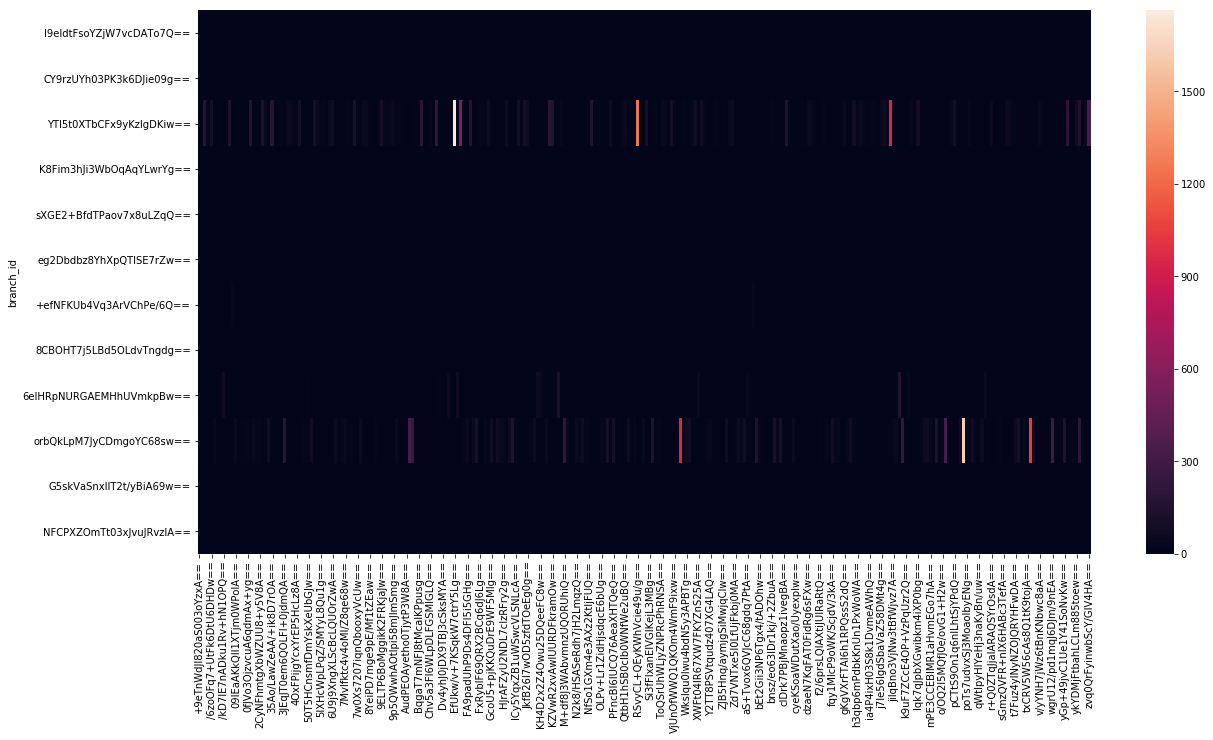

In [8]:
dist_branch_pivoted = df.groupBy('branch_id').pivot('item_code').agg(f.sum('quantity')).na.fill(0)
branch_pivoted = dist_branch_pivoted.toPandas().set_index('branch_id')
display(branch_pivoted.head())

colsums = branch_pivoted.values.sum(axis=0)
branch_pivoted_freq_items = branch_pivoted.loc[:,colsums > 10]

plt.figure(figsize=(20,10))
sns.heatmap(branch_pivoted_freq_items)

Members overlap - top 3 branches

In [26]:
def get_unique_members(df, branch_id):
    members = df \
        .where(f.col('branch_id') == branch_id) \
        .select('member_id') \
        .distinct() \
        .rdd \
        .map(lambda row: row['member_id']) \
        .collect()
    
    return set(members)

<matplotlib_venn._common.VennDiagram instance at 0x7fd9a0eb95a8>

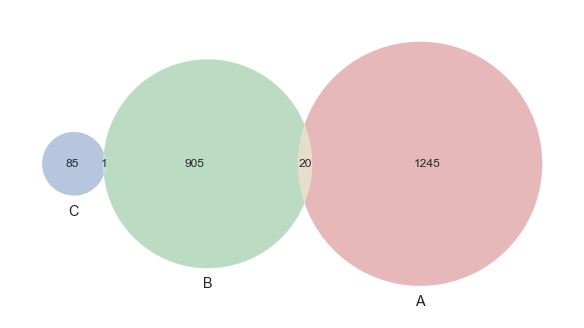

In [27]:
first = get_unique_members(df, 'YTl5t0XTbCFx9yKzIgDKiw==')
second = get_unique_members(df, 'orbQkLpM7JyCDmgoYC68sw==')
third = get_unique_members(df, '6eIHRpNURGAEMHhUVmkpBw==')

plt.figure(figsize=(10,10))
venn3([first, second, third])

members overlap - 2 vs. all

In [28]:
top_branches_df = df \
    .withColumn('branch_id_', f.when(f.col('branch_id').isin(['YTl5t0XTbCFx9yKzIgDKiw==', 'orbQkLpM7JyCDmgoYC68sw==']), f.col('branch_id')).otherwise('other')) \
    .drop('branch_id') \
    .select('branch_id_', 'member_id') \
    .toDF('branch_id', 'member_id')
    
top_branches_df \
    .groupBy('branch_id') \
    .agg(f.count('*').alias('count'), 
         f.countDistinct('member_id').alias('members')) \
    .orderBy(f.col('count').desc()) \
    .show(truncate=False)

+------------------------+-----+-------+
|branch_id               |count|members|
+------------------------+-----+-------+
|YTl5t0XTbCFx9yKzIgDKiw==|11881|1265   |
|orbQkLpM7JyCDmgoYC68sw==|10321|926    |
|other                   |1749 |220    |
+------------------------+-----+-------+



<matplotlib_venn._common.VennDiagram instance at 0x7fd9a0eb9bd8>

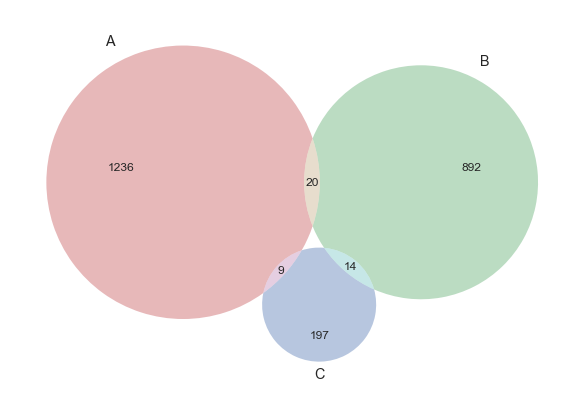

In [29]:
first = get_unique_members(top_branches_df, 'YTl5t0XTbCFx9yKzIgDKiw==')
second = get_unique_members(top_branches_df, 'orbQkLpM7JyCDmgoYC68sw==')
third = get_unique_members(top_branches_df, 'other')

plt.figure(figsize=(10,10))
venn3([first, second, third])

Conclusions:
- there is item overlap between branches, although the most popular branches not common
- very low rate of members overlap between branches

### Quantities analysis

In [30]:
df.agg(f.min('quantity'), f.max('quantity')).show()

+-------------+-------------+
|min(quantity)|max(quantity)|
+-------------+-------------+
|          1.0|         10.0|
+-------------+-------------+



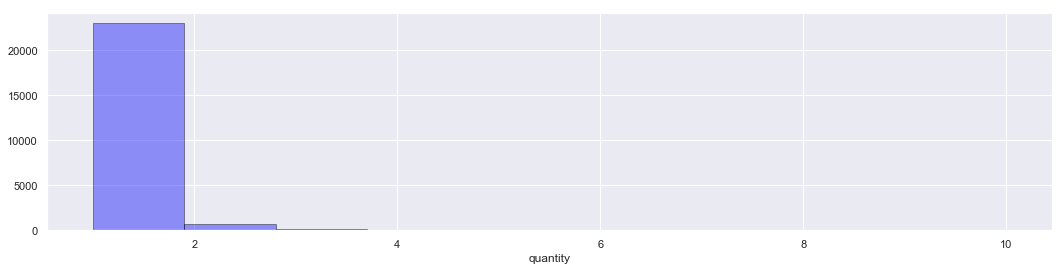

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(18,4))
_ = sns.distplot(df.toPandas()['quantity'].astype(int), hist=True, kde=False, 
             bins=10, color = 'blue',
             hist_kws={'edgecolor':'black'}, ax=ax)

### Pricing analysis

In [33]:
# to be added

## 3. Modeling

### Basket analysis

In [34]:
ldf = df.groupBy('member_id').agg(f.collect_set('item_code').alias('items'))
display(ldf.count())
ldf.toPandas().head(10)

2368

,member_id,items
0,0FA2aDI8HfSy46ebrgB7Gw==,"[Zd7VNTxe5I0LfUjFkbj0MA==, ghYSQoJ7cD5qz5xyaUK..."
1,2qkpKiHwld05XQE6CVGK7Q==,"[F+2KvtwlWQi+dG0kXlAmOg==, Dgh+xV3L57LXmS1rabU..."
2,6PxLTVhv9oAXAYTkTO+OYQ==,"[lrm/8BOs7fsdFAV54vvrYw==, jHu7upXBAll15UjO6G3..."
3,GBx8WjJH9L7xjCVglwoksA==,"[RSvyCL+QEyKWhVcie49u/g==, jHu7upXBAll15UjO6G3..."
4,IPKLX1E2sYio8xj0Q2j8sA==,"[48oESfoup3AaesU/txnFGg==, s/YRMbbs7rKxSDX6ZIp..."
5,K6zzgRlsokXVRAEEdye7cQ==,"[RSvyCL+QEyKWhVcie49u/g==, jHu7upXBAll15UjO6G3..."
6,WZDUwRtk7P3EM0+06vZRwA==,"[z80ghJXVZe9m59/5+Ydk2g==, /qnBHErZo5WmNu2USii..."
7,XEs010yvWo0KDHmOh/2iIw==,"[YbH7P1nijGfzkl88eb6BoQ==, KZVwR2xvAwlUURDFkra..."
8,e/UK1YWT8VluV+XiSIiTVA==,"[F+2KvtwlWQi+dG0kXlAmOg==, jHu7upXBAll15UjO6G3..."
9,e6yXGFLcoMZ2R1IIGW0tmA==,"[tzzjmMOfUGr3YdInfYU6kg==, wgrU12/pd1mqJ6DJm/9..."


In [35]:
fpGrowth = FPGrowth(itemsCol="items", minSupport=0.004, minConfidence=0.8)
model = fpGrowth.fit(ldf)

In [36]:
support = model.freqItemsets
display(support.count())
support.toPandas().head(10)

2132

,items,freq
0,[+s+fdDsIMAiolO7nuqFkaQ==],13
1,"[+s+fdDsIMAiolO7nuqFkaQ==, jHu7upXBAll15UjO6G3...",12
2,[jHu7upXBAll15UjO6G363A==],915
3,[WKL8btOf0IP1XUGCv4iCbQ==],909
4,[fLvECeyZDxnHjHW9HgbyFQ==],13
5,"[fLvECeyZDxnHjHW9HgbyFQ==, WKL8btOf0IP1XUGCv4i...",13
6,[RSvyCL+QEyKWhVcie49u/g==],498
7,"[RSvyCL+QEyKWhVcie49u/g==, jHu7upXBAll15UjO6G3...",361
8,[1n2KtPTBC/Iqo1PieHkTPA==],12
9,"[1n2KtPTBC/Iqo1PieHkTPA==, WKL8btOf0IP1XUGCv4i...",12


In [37]:
rules = model.associationRules
display(rules.count())
rules.toPandas().head(10)

1052

,antecedent,consequent,confidence,lift
0,[09lEaAKkQll1XTjm0WPoIA==],[WKL8btOf0IP1XUGCv4iCbQ==],1.000000,2.605061
1,"[BYTOVlyCS3t/UCgtmhmUWw==, tzzjmMOfUGr3YdInfYU...",[WKL8btOf0IP1XUGCv4iCbQ==],1.000000,2.605061
2,[gStLoof17gvJ1Du/W76H+w==],[peABMjc6cDEAD9mHo8n4ew==],0.928571,4.919143
3,[gStLoof17gvJ1Du/W76H+w==],[WKL8btOf0IP1XUGCv4iCbQ==],0.928571,2.418985
4,"[3JEqJT0em6QOLFl+0jdmQA==, z80ghJXVZe9m59/5+Yd...",[WKL8btOf0IP1XUGCv4iCbQ==],1.000000,2.605061
5,"[Wkslqu0lwu4bdN5y3APBTg==, tzzjmMOfUGr3YdInfYU...",[WKL8btOf0IP1XUGCv4iCbQ==],0.882353,2.298583
6,"[wgrU12/pd1mqJ6DJm/9nEA==, BYTOVlyCS3t/UCgtmhm...",[peABMjc6cDEAD9mHo8n4ew==],0.800000,4.238031
7,[sGmzQVFR+nIX6HABc3TefA==],[jHu7upXBAll15UjO6G363A==],0.909091,2.352707
8,"[M+df8J3WAbvmnzUQORUhiQ==, z80ghJXVZe9m59/5+Yd...",[peABMjc6cDEAD9mHo8n4ew==],0.916667,4.856078
9,"[OUYaGent37OF6nayZSHqSA==, jxTkX87qFnpaNt7dS+o...",[WKL8btOf0IP1XUGCv4iCbQ==],1.000000,2.605061


In [38]:
fp_predictions = model.transform(ldf)
fp_recommendations = fp_predictions\
.where(f.size('prediction') > 0)\
.select(f.col('member_id'), f.col('items').alias('fp_recommendations'))

display(fp_recommendations.count())
fp_recommendations.toPandas().head(10)

269

,member_id,fp_recommendations
0,vN3hF8JVFAaFNkluio0BJQ==,"[/6zoOFq7+UtFk6DtU6DHDw==, pCTtS9On1q6nILhtSjY..."
1,yHQG7BdHYy4wqHKssJlN5A==,"[5lXHcWpLPqZ/SMYyL8Qu1g==, 8Lusb6B58eALLBTB08b..."
2,B8Bivbclcnj5YdpPzjVO8A==,"[lqk7qJpbXGwibkm4iXP0bg==, EfUkw/v+7KSqkW7ctrY..."
3,wFMtsCXg2TFGl1g2qDzUkA==,"[oBoDgMo8YUKMJqIx8OSaCQ==, tzzjmMOfUGr3YdInfYU..."
4,8vGpdNAk/4KqIKrdoKPYSg==,"[oBoDgMo8YUKMJqIx8OSaCQ==, rGJ6scy9ti7JbnAvB/Z..."
5,UAsqHZqoQXlxy8i7kkeJ5A==,"[FxRybIF69QRX2BCq6dJ6Lg==, BZ/c2Wuut1ES8J+h3Md..."
6,VzoRIZSi8CJ8jlIcqPwPfg==,"[FxRybIF69QRX2BCq6dJ6Lg==, F+2KvtwlWQi+dG0kXlA..."
7,XBpjOn6ZiyZLhyWadqPRVQ==,"[KZVwR2xvAwlUURDFkramOw==, jHu7upXBAll15UjO6G3..."
8,A/RJ3yuoLT72yqijwQs8Bw==,"[9ELTP6BoMggikK2FRKjaJw==, cpxoiEvTWa3hXV8WMWZ..."
9,In0ulaDQ78N/giFmTL3DoQ==,"[lqk7qJpbXGwibkm4iXP0bg==, peABMjc6cDEAD9mHo8n..."


### Collaborative Filtering

In [39]:
ratings = df.groupBy('member_id', 'item_code').agg(f.sum('quantity').alias('quantity'))
display(ratings.count())
ratings.show()

13314

+--------------------+--------------------+--------+
|           member_id|           item_code|quantity|
+--------------------+--------------------+--------+
|ApJ94e5x84NtxljSY...|wWpTIPpHVTDZWDw0/...|     1.0|
|S0xGvejVjWCSoL+NV...|NBc8s48H+J3b68Ksk...|     1.0|
|sIfW8ZeFQMnxnOLnC...|tzzjmMOfUGr3YdInf...|     8.0|
|qsxVEiLEuDqpC4Xfn...|WKL8btOf0IP1XUGCv...|     1.0|
|14P5vT59YiFsWPyxg...|ZoCOMn3HnRNboY4FF...|     1.0|
|xr7Aqi7Y9mniUA5Ta...|/p/CicP/CvFCttO+r...|     3.0|
|CXg4P3jqibPnec7Ae...|ttdn0vjtXSGkSw5Yh...|     5.0|
|Bz2KwsqmI/7AXH9vf...|7w0Xs7207iqnQboox...|     1.0|
|GEET1Z5KeM8r36mZ+...|BkCWYyJq8vMRRIWqT...|     2.0|
|XPbiftcfCpvLwFBk/...|NfSo1GXm4e3AXz2Kt...|     2.0|
|RkqHG5MUrGU7etImh...|BkCWYyJq8vMRRIWqT...|     1.0|
|WNYZX12d0dNuI3Ww6...|fvYF/I26VCXWll+9T...|     1.0|
|AmTox7h/mKDwktgQ7...|B+HNfcqJoWeAQkdxg...|     1.0|
|My/MXfCvSG713naQ6...|jxTkX87qFnpaNt7dS...|     7.0|
|3N4MAva8qUOwPJjMI...|RSvyCL+QEyKWhVcie...|     1.0|
|pU5hvSZGMFH0BwlP4...|Nl0XdwCAyAeg5HrpE...|   

In [40]:
indexers = [StringIndexer(inputCol=c, outputCol="{}_index".format(c)).fit(ratings) for c in ['member_id', 'item_code']]
pipeline = Pipeline(stages=indexers)
indexed = pipeline.fit(ratings).transform(ratings)
indexed.show()

+--------------------+--------------------+--------+---------------+---------------+
|           member_id|           item_code|quantity|member_id_index|item_code_index|
+--------------------+--------------------+--------+---------------+---------------+
|ApJ94e5x84NtxljSY...|wWpTIPpHVTDZWDw0/...|     1.0|          561.0|          208.0|
|S0xGvejVjWCSoL+NV...|NBc8s48H+J3b68Ksk...|     1.0|         1739.0|           45.0|
|sIfW8ZeFQMnxnOLnC...|tzzjmMOfUGr3YdInf...|     8.0|         1847.0|            5.0|
|qsxVEiLEuDqpC4Xfn...|WKL8btOf0IP1XUGCv...|     1.0|          242.0|            1.0|
|14P5vT59YiFsWPyxg...|ZoCOMn3HnRNboY4FF...|     1.0|          825.0|          290.0|
|xr7Aqi7Y9mniUA5Ta...|/p/CicP/CvFCttO+r...|     3.0|           14.0|          266.0|
|CXg4P3jqibPnec7Ae...|ttdn0vjtXSGkSw5Yh...|     5.0|           99.0|           92.0|
|Bz2KwsqmI/7AXH9vf...|7w0Xs7207iqnQboox...|     1.0|         1291.0|          263.0|
|GEET1Z5KeM8r36mZ+...|BkCWYyJq8vMRRIWqT...|     2.0|          689

In [41]:
member_mapping = indexed.select("member_id", "member_id_index").distinct()
print member_mapping.count()
member_mapping.show()

2368
+--------------------+---------------+
|           member_id|member_id_index|
+--------------------+---------------+
|pU5hvSZGMFH0BwlP4...|          934.0|
|9oIwN+2O/nCU+EBG7...|           55.0|
|bzr4gTOAcpdviQBDM...|          151.0|
|x4EyVt+g/QQ10y5C2...|          143.0|
|n0SCPM0EOQxiOF3be...|          726.0|
|oHfbLXuC/RI5us1tT...|          452.0|
|rXsy/fmfBBWG0YP4h...|         1924.0|
|fnNtC7w1itA4iFt3P...|          400.0|
|XEX7HzCsgrVkI4Qam...|         2142.0|
|g75QlsiMCv71rVaZ4...|          720.0|
|QhizACIzczdC/CdNJ...|         1792.0|
|WGBX0mWiU6ieT/9YB...|         2351.0|
|2pKGgLs/x+wEBP6SA...|         2230.0|
|zb3XjNtXC0291slwA...|          191.0|
|hyAxYnb1vXxj+Uvxf...|         2200.0|
|2ncmnBbwN8stuui46...|         1445.0|
|57R47tNa81qaMLd17...|         1294.0|
|L872/09KKS/HudEm/...|         1213.0|
|JUmPnpderz/qsnzvQ...|          653.0|
|6kfUJYyfRrpM2bPuq...|         1020.0|
+--------------------+---------------+
only showing top 20 rows



In [42]:
item_mapping = indexed.select("item_code", "item_code_index").distinct()
print item_mapping.count()
item_mapping.show()

900
+--------------------+---------------+
|           item_code|item_code_index|
+--------------------+---------------+
|vUyatzD1UTIGuZnsD...|          231.0|
|CP4mIdjnFrAuwNo1J...|          552.0|
|VafPnHHxycSVQT+TT...|          485.0|
|l0FqwPWAVpR+LrXV0...|          564.0|
|uhs+ujIuq12JWqMCP...|          253.0|
|WdEYDfg4dg5ZJ9MjT...|          788.0|
|DIzlUWMFXE2lCoHgo...|          322.0|
|Si3fFIxanEIVGlKej...|          306.0|
|Hk02F31xu7NVjkOvl...|          759.0|
|Qud7Y2N6s4Hovl+DG...|          855.0|
|M7uDcgup0rbahxFDg...|          866.0|
|qMiKAFX2NuShY6Xj0...|          896.0|
|eJX8EwiO439RGRO6x...|          229.0|
|Ao7nJBV7BdBOe9zyN...|          810.0|
|F7PHBheI2+gt5avp9...|          796.0|
|CcbDeDtKcAVNp08lO...|          649.0|
|OLPv+Lr1ZidHjsdqc...|          126.0|
|twaDXeeaK06AUG9YK...|          438.0|
|rEFspI9NeIrCV/Ygy...|          636.0|
|voOrPs0Nt3PrLcGwo...|          575.0|
+--------------------+---------------+
only showing top 20 rows



In [43]:
train, test = indexed.randomSplit([0.8, 0.2])
display('train count: {0}, test count: {1}'.format(train.count(), test.count()))

'train count: 10638, test count: 2676'

In [44]:
als = ALS(maxIter=5,
          regParam=0.01,
          implicitPrefs=True,
          userCol="member_id_index",
          itemCol="item_code_index",
          ratingCol="quantity",
          coldStartStrategy="drop")

model = als.fit(train)

In [45]:
cf_predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse",
                                labelCol="quantity",
                                predictionCol="prediction")
rmse = evaluator.evaluate(cf_predictions)
display("Root-mean-square error = " + str(rmse))

'Root-mean-square error = 3.58441866691'

In [46]:
print cf_predictions.count()
cf_predictions.show()

2565
+--------------------+--------------------+--------+---------------+---------------+-------------+
|           member_id|           item_code|quantity|member_id_index|item_code_index|   prediction|
+--------------------+--------------------+--------+---------------+---------------+-------------+
|VbUPkQpSwDZ9dmyaP...|Xp+SoByYa6/Ku6/RR...|     2.0|          173.0|          148.0|   0.06249774|
|Br6KK3ewPmOJMtk1O...|Xp+SoByYa6/Ku6/RR...|     1.0|         1724.0|          148.0| 2.8033974E-4|
|IWBIDYMbE7/16CesN...|Jp2DevraMI3Urqsoy...|     1.0|          297.0|          463.0| 0.0021116233|
|UuKT32+H07rz8whHJ...|BK1WMgKcv77Y4Tbl9...|     1.0|          294.0|          496.0|  0.008872943|
|i4bFRTrM/KgjWzjel...|TFvedKjxEGVodJAvB...|     1.0|           26.0|          243.0|    0.0545348|
|JUmPnpderz/qsnzvQ...|TFvedKjxEGVodJAvB...|     1.0|          653.0|          243.0|  0.020446762|
|8vGpdNAk/4KqIKrdo...|TFvedKjxEGVodJAvB...|     1.0|          284.0|          243.0|-9.0331974E-4|
|OK1S

Generate top 10 items recommendations for each user

In [47]:
cf_member_recommendations = model.recommendForAllUsers(5)
print cf_member_recommendations.count()
cf_member_recommendations.show()

2334
+---------------+--------------------+
|member_id_index|     recommendations|
+---------------+--------------------+
|           1580|[[81, 0.41480753]...|
|            471|[[0, 0.7912898], ...|
|           1591|[[1, 0.75519717],...|
|           1342|[[33, 0.65346456]...|
|           2122|[[6, 0.1282438], ...|
|           2142|[[0, 0.9348256], ...|
|            463|[[1, 0.008219292]...|
|            833|[[0, 0.84881115],...|
|           1645|[[1, 0.9312371], ...|
|            496|[[2, 0.9085528], ...|
|           2366|[[1, 8.4563904E-4...|
|            148|[[3, 0.8500396], ...|
|           1088|[[1, 0.9748341], ...|
|           1238|[[0, 0.86713207],...|
|           1829|[[1, 0.88782823],...|
|           1959|[[1, 0.0970429], ...|
|            540|[[3, 1.0065043], ...|
|           1460|[[1, 1.0752398], ...|
|           1990|[[1, 0.8583073], ...|
|           1721|[[1, 0.6813202], ...|
+---------------+--------------------+
only showing top 20 rows



In [48]:
cf_member_recommendations = cf_member_recommendations\
.select('member_id_index', f.explode('recommendations'))\
.select('member_id_index', f.col('col.item_code_index'))\
.join(member_mapping, ['member_id_index']).join(item_mapping, ['item_code_index'])\
.groupBy('member_id').agg(f.collect_set('item_code').alias('cf_recommendations'))

cf_member_recommendations.toPandas().head(10)

,member_id,cf_recommendations
0,qvFtfG5sIVq4YZKd7JZqMQ==,"[oBoDgMo8YUKMJqIx8OSaCQ==, jHu7upXBAll15UjO6G3..."
1,hl1aNDmSBcbQFRrmlQgmcQ==,"[peABMjc6cDEAD9mHo8n4ew==, F+2KvtwlWQi+dG0kXlA..."
2,j5H9d3h3ywTDiG5XIOke3A==,"[oBoDgMo8YUKMJqIx8OSaCQ==, 7VGdrMibK+rT9FOwsFp..."
3,e6yXGFLcoMZ2R1IIGW0tmA==,"[tzzjmMOfUGr3YdInfYU6kg==, RSvyCL+QEyKWhVcie49..."
4,yHQG7BdHYy4wqHKssJlN5A==,"[RSvyCL+QEyKWhVcie49u/g==, jHu7upXBAll15UjO6G3..."
5,yUSSot1XYtCFshk42v0CLA==,"[peABMjc6cDEAD9mHo8n4ew==, RSvyCL+QEyKWhVcie49..."
6,hmblJu9fezicxylkbsoCMw==,"[F+2KvtwlWQi+dG0kXlAmOg==, jHu7upXBAll15UjO6G3..."
7,2qkpKiHwld05XQE6CVGK7Q==,"[F+2KvtwlWQi+dG0kXlAmOg==, Dgh+xV3L57LXmS1rabU..."
8,GBx8WjJH9L7xjCVglwoksA==,"[peABMjc6cDEAD9mHo8n4ew==, RSvyCL+QEyKWhVcie49..."
9,v0vltc8wY8qo3wL1OmIjQA==,"[RSvyCL+QEyKWhVcie49u/g==, z80ghJXVZe9m59/5+Yd..."


Generate top 10 user recommendations for each movie

In [49]:
item_recommendations = model.recommendForAllItems(100)
display(item_recommendations.count())
item_recommendations.show()

841

+---------------+--------------------+
|item_code_index|     recommendations|
+---------------+--------------------+
|            471|[[22, 0.046514876...|
|            463|[[219, 0.00905314...|
|            833|[[36, 1.4534939E-...|
|            496|[[60, 0.01374145]...|
|            148|[[12, 0.21656144]...|
|            540|[[448, 0.00955633...|
|            392|[[235, 0.00361892...|
|            243|[[3, 0.08164934],...|
|            623|[[219, 0.00265996...|
|            737|[[60, 0.007785306...|
|            897|[[15, 0.0772443],...|
|            858|[[36, 1.9080765E-...|
|             31|[[100, 0.720505],...|
|            516|[[12, 7.641675E-6...|
|            580|[[36, 9.74585E-6]...|
|            251|[[95, 0.045779828...|
|            451|[[60, 0.09573639]...|
|             85|[[163, 0.20228477...|
|            137|[[15, 0.22651677]...|
|            808|[[359, 0.03101666...|
+---------------+--------------------+
only showing top 20 rows



In [50]:
item_recommendations = item_recommendations\
.select('item_code_index', f.explode('recommendations'))\
.select('item_code_index', f.col('col.member_id_index'))\
.join(item_mapping, ['item_code_index']).join(member_mapping, ['member_id_index'])\
.groupBy('item_code').agg(f.collect_set('member_id').alias('recommendations'))

# item_recommendations.toPandas().head(10)

predict for specific members

In [51]:
# movies = ratings.select(als.getItemCol()).distinct().limit(3)
# movieSubSetRecs = model.recommendForItemSubset(movies, 10)predict for specific members

predict for specific items

In [52]:
# users = ratings.select(als.getUserCol()).distinct().limit(3)
# userSubsetRecs = model.recommendForUserSubset(users, 10)

### Most popular items recommendations

In [53]:
members_counts = df\
.groupBy('item_code')\
.agg(f.count('*').alias('members_count'))\
.orderBy(f.col('members_count').desc())\
.toPandas()

top_5_members_counts = members_counts.head(5)
top_5_members_counts

,item_code,members_count
0,EfUkw/v+7KSqkW7ctrY5Lg==,1707
1,peABMjc6cDEAD9mHo8n4ew==,1455
2,RSvyCL+QEyKWhVcie49u/g==,1183
3,WKL8btOf0IP1XUGCv4iCbQ==,974
4,jHu7upXBAll15UjO6G363A==,970


In [54]:
top_5_mc_str = ','.join(list(top_5_members_counts.item_code))
top_5_mc_str

u'EfUkw/v+7KSqkW7ctrY5Lg==,peABMjc6cDEAD9mHo8n4ew==,RSvyCL+QEyKWhVcie49u/g==,WKL8btOf0IP1XUGCv4iCbQ==,jHu7upXBAll15UjO6G363A=='

In [55]:
quantity_sums = df\
.groupBy('item_code')\
.agg(f.sum('quantity').alias('quantity_sum'))\
.orderBy(f.col('quantity_sum').desc())\
.toPandas()

top_5_quantity_sums = quantity_sums.head(5)
top_5_quantity_sums

,item_code,quantity_sum
0,EfUkw/v+7KSqkW7ctrY5Lg==,1801.0
1,peABMjc6cDEAD9mHo8n4ew==,1638.0
2,RSvyCL+QEyKWhVcie49u/g==,1261.0
3,tzzjmMOfUGr3YdInfYU6kg==,1051.0
4,WKL8btOf0IP1XUGCv4iCbQ==,974.0


In [56]:
top_5_qs_str = ','.join(list(top_5_quantity_sums.item_code))
top_5_qs_str

u'EfUkw/v+7KSqkW7ctrY5Lg==,peABMjc6cDEAD9mHo8n4ew==,RSvyCL+QEyKWhVcie49u/g==,tzzjmMOfUGr3YdInfYU6kg==,WKL8btOf0IP1XUGCv4iCbQ=='

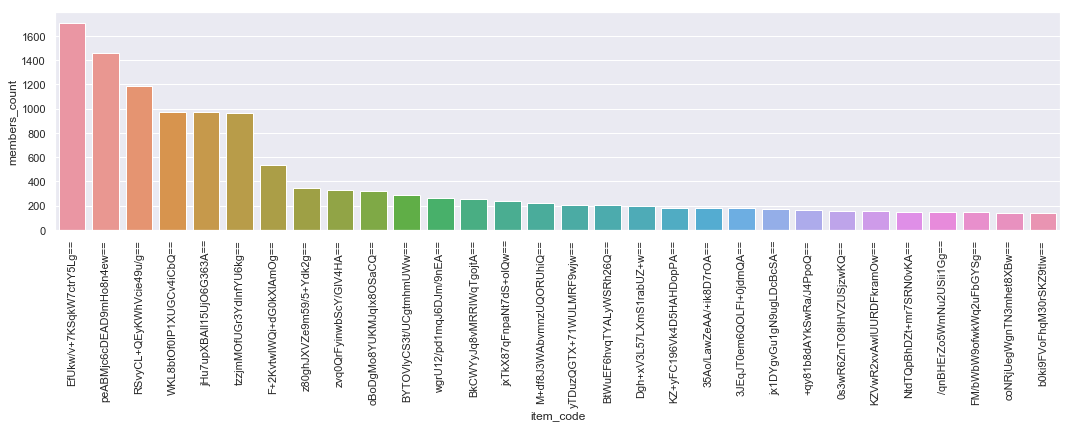

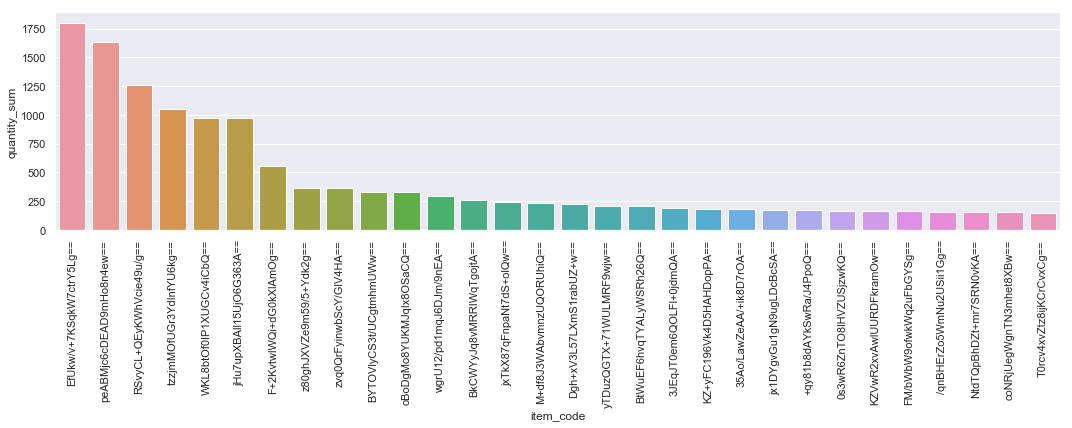

In [57]:
fig, ax = plt.subplots(1, 1, figsize=(18,4))

g = sns.barplot(x='item_code', y='members_count', data=members_counts.head(30), ax=ax)
locs, labels = plt.xticks()
_ = plt.setp(labels, rotation=90)

fig, ax = plt.subplots(1, 1, figsize=(18,4))
g = sns.barplot(x='item_code', y='quantity_sum', data=quantity_sums.head(30), ax=ax)
locs, labels = plt.xticks()
_ = plt.setp(labels, rotation=90)

### Random item recommendations (uniformly distributed)

In [58]:
import numpy as np

In [60]:
items_quantities = df.toPandas().item_code
random_items = np.random.choice(items_quantities, 5)
random_items

array([u'RSvyCL+QEyKWhVcie49u/g==', u'PvgVQW93UJj+l3AEAVxhkw==',
       u'EfUkw/v+7KSqkW7ctrY5Lg==', u'jx1DYgvGu1gN9ugLDcBcSA==',
       u'j7X4viqp1sZKBOOrn2P+7g=='], dtype=object)

In [61]:
df\
.where(f.col('item_code').isin(*random_items))\
.groupBy('item_code').agg(f.count('*'), f.sum('quantity'))\
.show(truncate=False)

+------------------------+--------+-------------+
|item_code               |count(1)|sum(quantity)|
+------------------------+--------+-------------+
|j7X4viqp1sZKBOOrn2P+7g==|72      |77.0         |
|RSvyCL+QEyKWhVcie49u/g==|1183    |1261.0       |
|jx1DYgvGu1gN9ugLDcBcSA==|171     |172.0        |
|EfUkw/v+7KSqkW7ctrY5Lg==|1707    |1801.0       |
|PvgVQW93UJj+l3AEAVxhkw==|18      |19.0         |
+------------------------+--------+-------------+



In [62]:
random_items_str = ','.join(list(random_items))
random_items_str

u'RSvyCL+QEyKWhVcie49u/g==,PvgVQW93UJj+l3AEAVxhkw==,EfUkw/v+7KSqkW7ctrY5Lg==,jx1DYgvGu1gN9ugLDcBcSA==,j7X4viqp1sZKBOOrn2P+7g=='

### Benchmarking the results of all methods

In [63]:
full_recs = cf_member_recommendations\
.join(fp_recommendations, ['member_id'], 'fullouter')\
.drop(fp_recommendations['member_id'])\
.withColumn('top_5_by_members', f.lit(top_5_mc_str))\
.withColumn('top_5_by_quantity', f.lit(top_5_qs_str))\
.withColumn('random_5', f.lit(random_items_str))

full_recs.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|           member_id|  cf_recommendations|  fp_recommendations|    top_5_by_members|   top_5_by_quantity|            random_5|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|0FA2aDI8HfSy46ebr...|[oBoDgMo8YUKMJqIx...|                null|EfUkw/v+7KSqkW7ct...|EfUkw/v+7KSqkW7ct...|RSvyCL+QEyKWhVcie...|
|2qkpKiHwld05XQE6C...|[F+2KvtwlWQi+dG0k...|                null|EfUkw/v+7KSqkW7ct...|EfUkw/v+7KSqkW7ct...|RSvyCL+QEyKWhVcie...|
|6PxLTVhv9oAXAYTkT...|[oBoDgMo8YUKMJqIx...|                null|EfUkw/v+7KSqkW7ct...|EfUkw/v+7KSqkW7ct...|RSvyCL+QEyKWhVcie...|
|GBx8WjJH9L7xjCVgl...|[peABMjc6cDEAD9mH...|                null|EfUkw/v+7KSqkW7ct...|EfUkw/v+7KSqkW7ct...|RSvyCL+QEyKWhVcie...|
|IPKLX1E2sYio8xj0Q...|[coNRjUegWgnTN3mh...|                null|EfUkw/v+7KSqkW7ct...|EfUkw/v+7KSqkW7ct..

In [64]:
full_recs.toPandas().head(20)

,member_id,cf_recommendations,fp_recommendations,top_5_by_members,top_5_by_quantity,random_5
0,0FA2aDI8HfSy46ebrgB7Gw==,"[oBoDgMo8YUKMJqIx8OSaCQ==, 3JEqJT0em6QOLFl+0jd...",None,"EfUkw/v+7KSqkW7ctrY5Lg==,peABMjc6cDEAD9mHo8n4e...","EfUkw/v+7KSqkW7ctrY5Lg==,peABMjc6cDEAD9mHo8n4e...","RSvyCL+QEyKWhVcie49u/g==,PvgVQW93UJj+l3AEAVxhk..."
1,2qkpKiHwld05XQE6CVGK7Q==,"[F+2KvtwlWQi+dG0kXlAmOg==, Dgh+xV3L57LXmS1rabU...",None,"EfUkw/v+7KSqkW7ctrY5Lg==,peABMjc6cDEAD9mHo8n4e...","EfUkw/v+7KSqkW7ctrY5Lg==,peABMjc6cDEAD9mHo8n4e...","RSvyCL+QEyKWhVcie49u/g==,PvgVQW93UJj+l3AEAVxhk..."
2,6PxLTVhv9oAXAYTkTO+OYQ==,"[oBoDgMo8YUKMJqIx8OSaCQ==, RSvyCL+QEyKWhVcie49...",None,"EfUkw/v+7KSqkW7ctrY5Lg==,peABMjc6cDEAD9mHo8n4e...","EfUkw/v+7KSqkW7ctrY5Lg==,peABMjc6cDEAD9mHo8n4e...","RSvyCL+QEyKWhVcie49u/g==,PvgVQW93UJj+l3AEAVxhk..."
3,GBx8WjJH9L7xjCVglwoksA==,"[peABMjc6cDEAD9mHo8n4ew==, RSvyCL+QEyKWhVcie49...",None,"EfUkw/v+7KSqkW7ctrY5Lg==,peABMjc6cDEAD9mHo8n4e...","EfUkw/v+7KSqkW7ctrY5Lg==,peABMjc6cDEAD9mHo8n4e...","RSvyCL+QEyKWhVcie49u/g==,PvgVQW93UJj+l3AEAVxhk..."
4,IPKLX1E2sYio8xj0Q2j8sA==,"[coNRjUegWgnTN3mhet8XBw==, z80ghJXVZe9m59/5+Yd...",None,"EfUkw/v+7KSqkW7ctrY5Lg==,peABMjc6cDEAD9mHo8n4e...","EfUkw/v+7KSqkW7ctrY5Lg==,peABMjc6cDEAD9mHo8n4e...","RSvyCL+QEyKWhVcie49u/g==,PvgVQW93UJj+l3AEAVxhk..."
5,K6zzgRlsokXVRAEEdye7cQ==,"[RSvyCL+QEyKWhVcie49u/g==, jHu7upXBAll15UjO6G3...",None,"EfUkw/v+7KSqkW7ctrY5Lg==,peABMjc6cDEAD9mHo8n4e...","EfUkw/v+7KSqkW7ctrY5Lg==,peABMjc6cDEAD9mHo8n4e...","RSvyCL+QEyKWhVcie49u/g==,PvgVQW93UJj+l3AEAVxhk..."
6,WZDUwRtk7P3EM0+06vZRwA==,"[BtWuEF6hvqTYALyWSRh26Q==, z80ghJXVZe9m59/5+Yd...",None,"EfUkw/v+7KSqkW7ctrY5Lg==,peABMjc6cDEAD9mHo8n4e...","EfUkw/v+7KSqkW7ctrY5Lg==,peABMjc6cDEAD9mHo8n4e...","RSvyCL+QEyKWhVcie49u/g==,PvgVQW93UJj+l3AEAVxhk..."
7,XEs010yvWo0KDHmOh/2iIw==,"[KZVwR2xvAwlUURDFkramOw==, jHu7upXBAll15UjO6G3...",None,"EfUkw/v+7KSqkW7ctrY5Lg==,peABMjc6cDEAD9mHo8n4e...","EfUkw/v+7KSqkW7ctrY5Lg==,peABMjc6cDEAD9mHo8n4e...","RSvyCL+QEyKWhVcie49u/g==,PvgVQW93UJj+l3AEAVxhk..."
8,e/UK1YWT8VluV+XiSIiTVA==,"[F+2KvtwlWQi+dG0kXlAmOg==, Dgh+xV3L57LXmS1rabU...",None,"EfUkw/v+7KSqkW7ctrY5Lg==,peABMjc6cDEAD9mHo8n4e...","EfUkw/v+7KSqkW7ctrY5Lg==,peABMjc6cDEAD9mHo8n4e...","RSvyCL+QEyKWhVcie49u/g==,PvgVQW93UJj+l3AEAVxhk..."
9,e6yXGFLcoMZ2R1IIGW0tmA==,"[tzzjmMOfUGr3YdInfYU6kg==, RSvyCL+QEyKWhVcie49...",None,"EfUkw/v+7KSqkW7ctrY5Lg==,peABMjc6cDEAD9mHo8n4e...","EfUkw/v+7KSqkW7ctrY5Lg==,peABMjc6cDEAD9mHo8n4e...","RSvyCL+QEyKWhVcie49u/g==,PvgVQW93UJj+l3AEAVxhk..."
